In [ ]:
from __future__ import print_function, division
import sys, time
import molgrid

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('bright')
from IPython import display
%matplotlib inline

In [ ]:
data_file, data_root = '/home/mtr22/cnn/gan/data/carbon.types', '/home/mtr22/cnn/gan/data/'
#data_file, data_root = '/home/mtr22/cnn/gan/data/single.types', '/home/mtr22/PDBbind/refined-set/'

data_loader = molgrid.ExampleProvider(molgrid.NullIndexTyper(),
                                      molgrid.defaultGninaLigandTyper,
                                      make_vector_types=True,
                                      data_root=data_root,
                                      shuffle=True)
data_loader.populate(data_file)

elems = ['C','C','C','C','Br','Cl','Fl','N','N','O','O','S','P','Zn','Li']

n_types = molgrid.defaultGninaLigandTyper.num_types()
radii = np.array(list(molgrid.defaultGninaLigandTyper.get_type_radii()))

batch = data_loader.next_batch(1)
tuple(batch[0].coord_sets[1].center())

In [ ]:
class MolNet(nn.Module):
    '''
    Base class for a model that generates molecular structures.
    '''
    def __init__(self, n_atoms, n_types):
        super(MolNet, self).__init__()
        
        self.n_atoms = n_atoms
        self.n_types = n_types
        
    def to(self, device):
        ret = super(MolNet, self).to(device)
        self.device = device
        return ret


class MolStruct(MolNet):
    '''
    A directly optimizable molecular structure.
    '''
    def __init__(self, n_atoms, n_types, *args):
        super(MolStruct, self).__init__(n_atoms, n_types)
        
        self.coords = nn.Parameter(torch.randn(n_atoms, 3))
        self.types = nn.Parameter(torch.randn(n_atoms, n_types+1))
        
    def forward(self, input, temp=0.0):
        
        batch_size = input.shape[0]
        
        coords = self.coords.unsqueeze(0).repeat(batch_size, 1, 1)
        types = F.softmax(self.types.unsqueeze(0).repeat(batch_size, 1, 1), dim=-1)
     
        if temp:
            coords += temp * torch.randn(batch_size, self.n_atoms, 3, device=self.device)
    
        return coords, types

    
class MolgridCNN(MolNet):
    '''
    A model that takes a molgrid as input, encodes it to a latent
    vector with a CNN, and then decodes it as a molecular structure
    using only feedforward layers.
    '''
    def __init__(self, n_atoms, n_types, dims, n_latent):
        super(MolgridCNN, self).__init__(n_atoms, n_types)
        
        self.conv1 = nn.Conv3d(n_types, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(2)
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool3d(2)
        self.last_layer_size = 128 * dims[1]//16 * dims[2]//16 * dims[3]//16
        self.fc_latent1 = nn.Linear(self.last_layer_size, n_latent)
        self.fc_latent2 = nn.Linear(n_latent, n_latent)
        self.fc_coords = nn.Linear(n_latent, n_atoms*3)
        self.fc_types = nn.Linear(n_latent, n_atoms*(n_types+1)) # include dummy type
    
    def forward(self, input, temp=0.0):
        
        batch_size = input.shape[0]
        
        # get latent encoding of true density from CNN
        x = F.relu(self.conv1(input))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.reshape(-1, self.last_layer_size)
        x = F.relu(self.fc_latent1(x))
        x = F.relu(self.fc_latent2(x))
        coords = self.fc_coords(x).view(batch_size, self.n_atoms, 3)
        types = F.softmax(self.fc_types(x).view(batch_size, self.n_atoms, -1), dim=-1)
        #types = torch.zeros(batch_size, self.n_atoms, self.n_types+1, device='cuda')
        #types[:,:,9] = 1
        
        if temp:
            coords += temp * torch.randn(batch_size, self.n_atoms, 3, device=self.device)
        
        return coords, types
        

class MolgridRNN(nn.Module):
    '''
    A model that takes a molgrid as input, encodes it to a latent
    vector with a CNN, and then decodes it as a molecular structure
    with an LSTM.
    '''
    def __init__(self, n_atoms, n_types, dims, n_latent):
        super(MolgridRNN, self).__init__(n_atoms, n_types)
        
        self.conv1 = nn.Conv3d(n_types, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(2)
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool3d(2)
        self.last_layer_size = 128 * dims[1]//16 * dims[2]//16 * dims[3]//16
        self.fc_latent = nn.Linear(self.last_layer_size, n_latent)
        
        self.lstm = nn.LSTM(n_types+4, n_latent)
        self.fc_coords = nn.Linear(n_latent, 3)
        self.fc_types = nn.Linear(n_latent, n_types+1) # include dummy type
    
    def forward(self, input, temp=0.0):
        
        batch_size = input.shape[0]
        
        # get latent encoding of true density from CNN
        x = F.relu(self.conv1(input))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.reshape(-1, self.last_layer_size)
        latent = F.elu(self.fc_latent(x))
        
        # init LSTM hidden state to latent encoding and cell to zero
        # use sequence-first dim order, more efficient for LSTM
        n_latent = self.fc_latent.out_features
        lstm_h = latent.view(1, batch_size, n_latent)
        lstm_c = torch.zeros(1, batch_size, n_latent, device=self.device)
        
        # first input atom is dummy type, otherwise previous output atom
        xyz = torch.zeros(1, batch_size, 3, device=self.device)
        t = torch.zeros(1, batch_size, n_types+1, device=self.device)
        t[:,:,-1] = 1
        
        # accumulate output atoms in tensors, using batch-first dim order
        coords = torch.zeros(batch_size, 0, 3, device=self.device)
        types = torch.zeros(batch_size, 0, n_types+1, device=self.device)

        for i in range(self.n_atoms):
            
            xyzt = torch.cat((xyz, t), dim=-1)
            _, (lstm_h, lstm_c) = self.lstm(xyzt, (lstm_h, lstm_c))
            xyz = self.fc_coords(lstm_h)
            t = F.softmax(self.fc_types(lstm_h), dim=-1)
            
            if temp:
                xyz += temp * torch.randn(1, batch_size, 3, device=self.device)
            
            coords = torch.cat((coords, xyz.permute(1, 0, 2)), dim=1)
            types = torch.cat((types, t.permute(1, 0, 2)), dim=1)
        
        return coords, types


class Attention(nn.Module):
    
    def forward(self, Q, K, V):
        d_k = K.shape[2]
        QKT = torch.bmm(Q, K.transpose(1, 2))
        return torch.bmm(F.softmax(QKT / np.sqrt(d_k), dim=2), V)


def weight_init(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
    elif isinstance(m, nn.LSTM):
        for p in m.parameters():
            nn.init.uniform_(p.data)


(-1, 4)

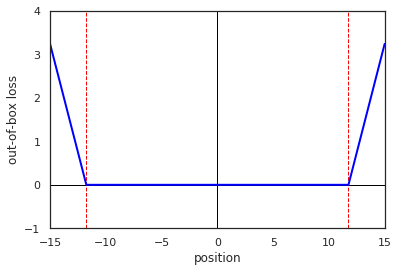

In [4]:
def write_xyz_and_arrows(types, coords, dcoords, out, out2, sample=False, state=0, scale=1):
    '''
    From BxNxT array of types, BxNx3 array of coords, and BxNx3 gradient,
    generate a multi model xyz file (plus gradient) and a pymol script of
    gradient arrows. Optionally sample atom type vector instead of max.
    '''
    i = 0
    for ts, xyzs, dxyzs in zip(types, coords, dcoords):
        out.write('{:d}\n\n'.format(len(ts)))
        
        j = 0
        for t, (x,y,z), (dx,dy,dz) in zip(ts, xyzs, dxyzs):
        
            if sample:
                elem = np.random.choice(elems, p=t)
            else:
                elem = elems[np.argmax(t)]

            out.write('{:s}   {:f}  {:f}  {:f}  {:f}  {:f}  {:f}\n'.format(elem,x,y,z,dx,dy,dz))
            
            x2 = x + scale*dx
            y2 = y + scale*dy
            z2 = z + scale*dz
            out2.write('cgo_arrow [{}, {}, {}], [{}, {}, {}]'.format(x,y,z,x2,y2,z2) + 
                       ', name=arrow_{}_{}, state={}, color=black'.format(i, j, state) +
                       ', radius=0.05, hradius=0.1, hlength=0.25\n')
            j += 1
        i += 1
    
def out_of_box_loss(c, max_val):
    '''hingey loss at box boundaries'''
    return (F.relu(abs(c)-max_val)).sum()

def grad_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1/2)
    return total_norm

def get_ylim(vals):
    min_val = 0 #min(vals)
    max_val = max(vals)
    val_range = max_val - min_val
    return min_val - 0.1*val_range, max_val + 0.1*val_range

x_min, x_max = np.array([-15, 15])
y_min, y_max = np.array([-1, 4])
max_val = 23.5/2
x = torch.arange(x_min, x_max, 0.01)
y = torch.tensor([out_of_box_loss(x_, max_val) for x_ in x])
plt.figure()
plt.ylabel('out-of-box loss')
plt.xlabel('position')
plt.hlines(0, x_min, x_max, 'k', lw=1)
plt.vlines(0, y_min, y_max, 'k', lw=1)
plt.vlines([-max_val, max_val], y_min, y_max, 'r', 'dashed', lw=1)
plt.plot(x, y, 'b', lw=2)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

converged


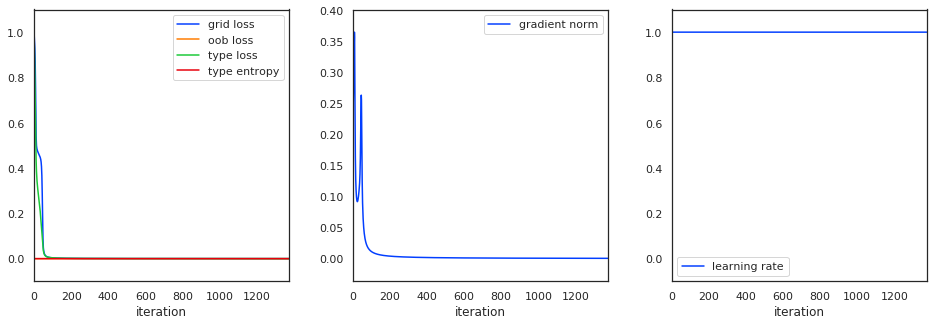

In [6]:
gmaker = molgrid.GridMaker(resolution=0.5,
                           dimension=23.5,
                           radius_scale=1,
                           radius_type_indexed=True)

dims = gmaker.grid_dimensions(n_types)
grid_size = dims[0] * dims[1] * dims[2] * dims[3]

c2grid = molgrid.Coords2Grid(gmaker, center=(0,0,0))

device = 'cpu'
n_atoms = 2
n_latent = 128
temp = 0.0
model = MolStruct(n_atoms, n_types, dims, n_latent).to(device)
model.apply(weight_init)

optimizer = optim.SGD(model.parameters(), lr=1e-0, momentum=0)
lr_policy = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)

losses = []
grid_losses = []
oob_losses = []
type_losses = []
type_entropies = []
grad_norms = []
lrs = []

loss_out = open('loss.txt', 'wt')
pred_out = open('pred.xyz', 'wt')
arrows_out = open('pred_arrows.pymol', 'wt')

batch_size = 1
n_iterations = 2000
step_interval = 2000
print_interval = 1

grid_true = torch.empty(batch_size, *dims, dtype=torch.float32, device=device)
type_count_true = torch.empty(batch_size, n_types, dtype=torch.float32, device=device)
batch_radii = torch.tensor(np.tile(radii, (batch_size, 1)), dtype=torch.float32, device=device)

fig, ax = plt.subplots(1, 3, sharex=True, squeeze=True, figsize=(16, 5), gridspec_kw=dict(wspace=0.25))
ax[0].plot(grid_losses, label='grid loss')
ax[0].plot(oob_losses, label='oob loss')
ax[0].plot(type_losses, label='type loss')
ax[0].plot(type_entropies, label='type entropy')
ax[0].legend(loc=0)
ax[0].set_xlabel('iteration')
ax[1].plot(grad_norms, label='gradient norm')
ax[1].legend(loc=0)
ax[1].set_xlabel('iteration')
ax[2].plot(lrs, label='learning rate')
ax[2].legend(loc=0)
ax[2].set_xlabel('iteration')

i = 0
while i < n_iterations:
    try:
        optimizer.zero_grad()

        batch = data_loader.next_batch(batch_size)
        batch.sum_types(type_count_true)

        gmaker.forward(batch, grid_true, random_rotation=False) #TODO why doesn't training work with rotation?
        coords, typesd = model(grid_true, temp)
        types = typesd[:,:,:-1].clone()
        grid_gen = c2grid(coords, types, batch_radii)

        type_entropy = -torch.sum(typesd * torch.log(typesd)) / (batch_size * n_atoms)
        grid_loss = F.mse_loss(grid_true, grid_gen)
        oob_loss  = out_of_box_loss(coords, max_val=11.5)
        type_loss = F.mse_loss(type_count_true, types.sum(dim=1))
        
        if i == 0:
            k_grid_loss    = 1/float(grid_loss)
            k_oob_loss     = 1
            k_type_loss    = 1/float(type_loss)
            k_type_entropy = 0/float(type_entropy)

        grid_loss    *= k_grid_loss
        oob_loss     *= k_oob_loss
        type_loss    *= k_type_loss
        type_entropy *= k_type_entropy
        
        loss = grid_loss + oob_loss + type_loss + type_entropy

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 100)

        losses.append(float(loss))
        grid_losses.append(float(grid_loss))
        oob_losses.append(float(oob_loss))
        type_losses.append(float(type_loss))
        type_entropies.append(float(type_entropy))
        grad_norms.append(float(grad_norm(model)))
        lrs.append(float(optimizer.param_groups[0]['lr']))

        optimizer.step()
        i += 1

        row = (i, losses[-1], grid_losses[-1], oob_losses[-1], type_losses[-1], grad_norms[-1])
        loss_out.write('%i %f %f %f %f %f\n' % row)
        loss_out.flush()

        if i % print_interval == 0:
            #print('[%i] loss=%f, grid_loss=%f, oob_loss=%f, type_loss=%f, grad_norm=%f' % row)

            if True: # dynamic plotting
                ax[0].get_lines()[0].set_data(range(i), grid_losses)
                ax[0].get_lines()[1].set_data(range(i), oob_losses)
                ax[0].get_lines()[2].set_data(range(i), type_losses)
                ax[0].get_lines()[3].set_data(range(i), type_entropies)
                ax[0].set_xlim(0, i)
                ax[0].set_ylim(get_ylim(grid_losses + oob_losses + type_losses + type_entropies))

                ax[1].get_lines()[0].set_data(range(i), grad_norms)
                ax[1].set_xlim(0, i)
                ax[1].set_ylim(get_ylim(grad_norms))

                ax[2].get_lines()[0].set_data(range(i), lrs)
                ax[2].set_xlim(0, i)
                ax[2].set_ylim(get_ylim(lrs))

                display.display(fig)
                display.clear_output(wait=True)
                
            optimizer.zero_grad()

            gmaker.forward(batch, grid_true, random_rotation=False)
            coords, typesd = model(grid_true)
            coords.retain_grad()
            types = typesd[:,:,:-1].clone()
            grid_gen = c2grid(coords, types, batch_radii)

            type_entropy = -torch.sum(typesd * torch.log(typesd)) / (batch_size * n_atoms)
            grid_loss = F.mse_loss(grid_true, grid_gen)
            oob_loss  = out_of_box_loss(coords, max_val=11.5)
            type_loss = F.mse_loss(type_count_true, types.sum(dim=1))
            
            grid_loss    *= k_grid_loss
            oob_loss     *= k_oob_loss
            type_loss    *= k_type_loss
            type_entropy *= k_type_entropy
            loss = grid_loss + oob_loss + type_loss + type_entropy
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 100)

            write_xyz_and_arrows(
                typesd.detach().cpu().numpy()[:1,:,:],
                coords.detach().cpu().numpy()[:1,:,:],
                coords.grad.detach().cpu().numpy()[:1,:,:],
                pred_out, arrows_out, sample=True,
                state=i//print_interval,
                scale=-5)
            pred_out.flush()
            arrows_out.flush()

            if grad_norms[-1] < 5e-4:
                print('converged')
                break

        if i % step_interval == 0:
            lr_policy.step()
            
    except KeyboardInterrupt:
        print('interrupted')
        break


In [ ]:
print(k_grid_loss, k_oob_loss, k_type_loss, k_type_entropy)

In [ ]:
elems